# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.sql import Window

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify_UDACITY").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
data_file = 'mini_sparkify_event_data.json'

In [4]:
df = spark.read.json(data_file)

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [7]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   artist         228108 non-null  object 
 1   auth           286500 non-null  object 
 2   firstName      278154 non-null  object 
 3   gender         278154 non-null  object 
 4   itemInSession  286500 non-null  int64  
 5   lastName       278154 non-null  object 
 6   length         228108 non-null  float64
 7   level          286500 non-null  object 
 8   location       278154 non-null  object 
 9   method         286500 non-null  object 
 10  page           286500 non-null  object 
 11  registration   278154 non-null  float64
 12  sessionId      286500 non-null  int64  
 13  song           228108 non-null  object 
 14  status         286500 non-null  int64  
 15  ts             286500 non-null  int64  
 16  userAgent      278154 non-null  object 
 17  userId         286500 non-nul

In [8]:
# let us check if there are any empty userIds - we will use spark

df.filter(df.userId == '').count()

8346

In [9]:
# now lets do the same for the sessionId

df.filter(df.sessionId == '').count()

0

In [10]:
# okay know we know that we should drop the userId rows where userId == 0

df = df.filter(df.userId != '')

In [11]:
assert df.filter(df.userId == '').count() == 0, 'You still have empty userId' 
print("No empty userId!")

No empty userId!


In [12]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   artist         228108 non-null  object 
 1   auth           278154 non-null  object 
 2   firstName      278154 non-null  object 
 3   gender         278154 non-null  object 
 4   itemInSession  278154 non-null  int64  
 5   lastName       278154 non-null  object 
 6   length         228108 non-null  float64
 7   level          278154 non-null  object 
 8   location       278154 non-null  object 
 9   method         278154 non-null  object 
 10  page           278154 non-null  object 
 11  registration   278154 non-null  int64  
 12  sessionId      278154 non-null  int64  
 13  song           228108 non-null  object 
 14  status         278154 non-null  int64  
 15  ts             278154 non-null  int64  
 16  userAgent      278154 non-null  object 
 17  userId         278154 non-nul

We have removed <b>8346</b> rows from the data set in order, now we can start exploring the dataset

Rest of the exploratory analysis will be done below

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
for col in df.schema.names:
    print(col, df.select(col).dropDuplicates().count())

artist 17656
auth 2
firstName 189
gender 2
itemInSession 1311
lastName 173
length 14866
level 2
location 114
method 2
page 19
registration 225
sessionId 2312
song 58481
status 3
ts 269770
userAgent 56
userId 225


Based on the above we know that:
* we have <b>225 unqiue users</b>
* we have <b>19 unique pages</b>
* we have <b>2312 unqiue sessions</b>
* etc.

In [14]:
# let us get unique values for the page
df.select('page').dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [15]:
churn_function = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

In [16]:
df = df.withColumn('churn', churn_function('page')).orderBy(['userId', 'churn'], ascending=False)

In [17]:
win_val = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [18]:
df = df.withColumn('churn', Fsum('churn').over(win_val))

In [19]:
df.filter(df.churn == 1).count()

44864

In [20]:
df.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [21]:
df.dropDuplicates(['userId', 'gender']).groupby('churn', 'gender').count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



We can see that there are <b>52</b> users that churned

In [22]:
df.groupBy('page').count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [23]:
df_2 = df.groupBy('page').count()
df_2.show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [24]:
dft = df_2.toPandas()

In [25]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   page    19 non-null     object
 1   count   19 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 432.0+ bytes


In [26]:
dft['count'] = dft['count'].apply(lambda x: int(x))

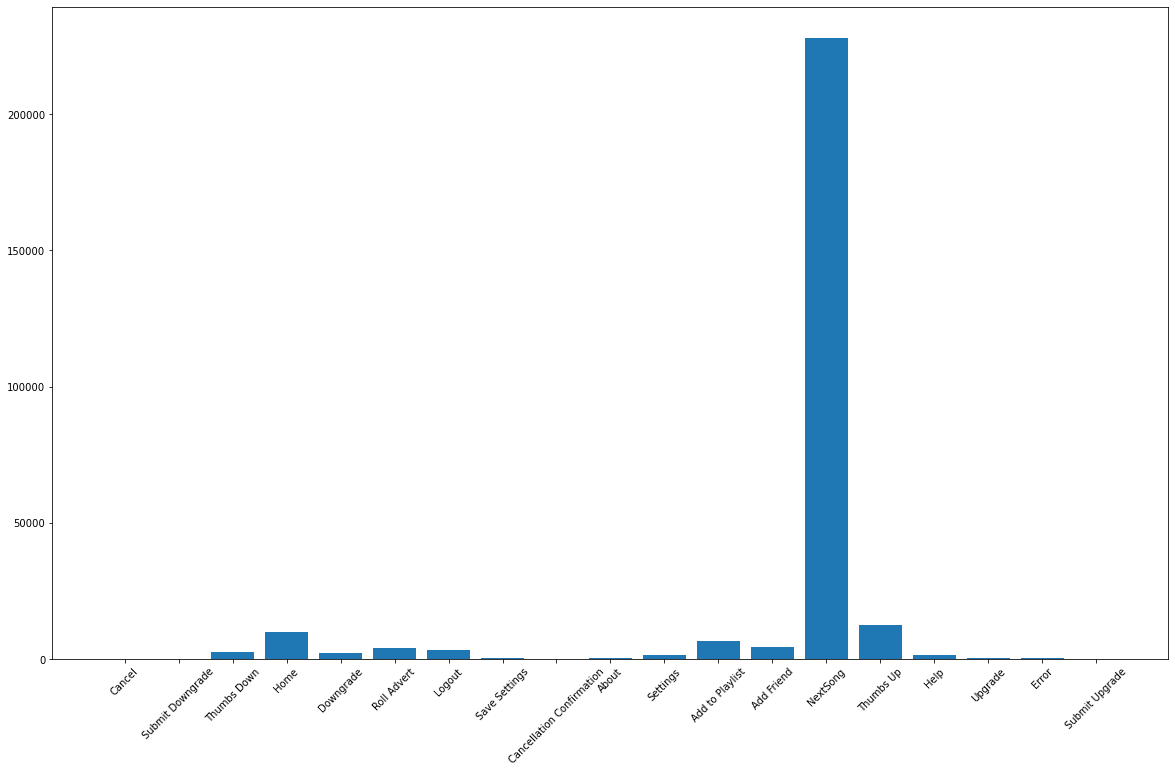

In [27]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.bar(dft['page'], height=dft['count'])
plt.xticks(rotation=45)
plt.show()

Considering that above graphs is very unreadable we will try to illustrate the same without 'NextSong' in order to be able to see better what is going on with other pages

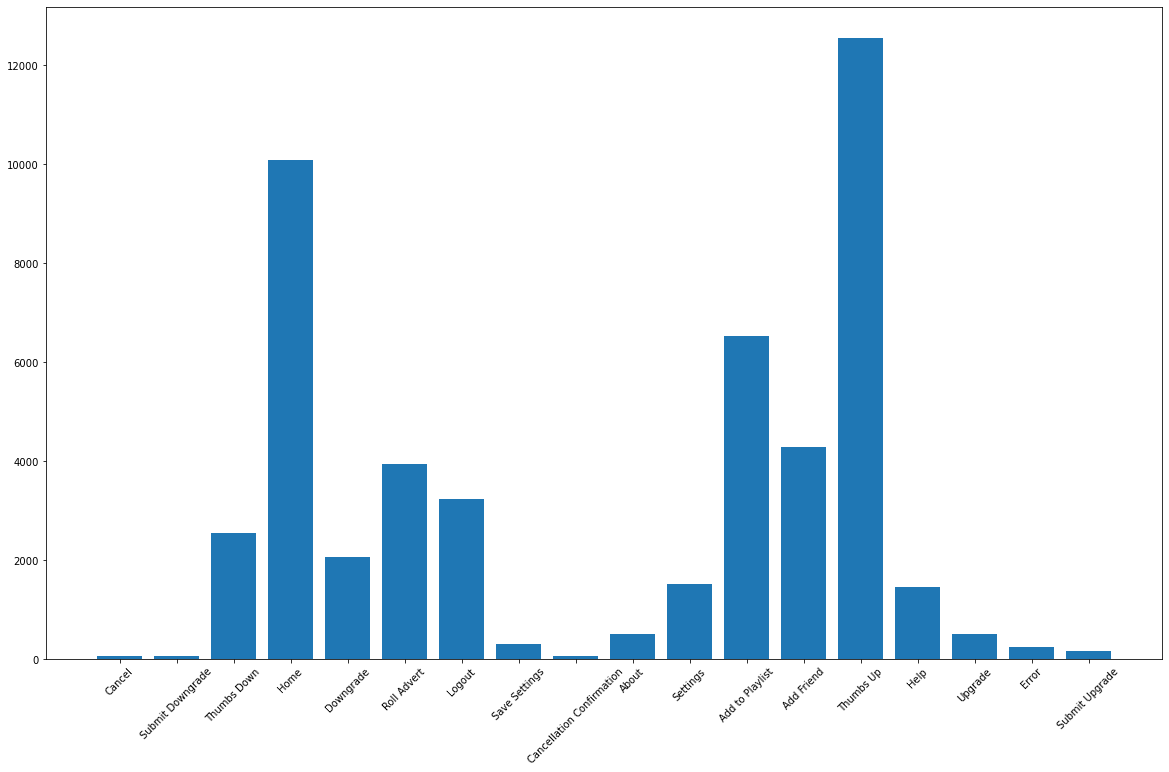

In [28]:
fig, ax = plt.subplots(figsize=[20, 12])
ax.bar(dft[dft['page'] != 'NextSong']['page'],
      height = dft[dft['page'] != 'NextSong']['count'])
plt.xticks(rotation=45)
plt.show()

In [29]:
df.groupBy('gender').count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



In [30]:
df_gender = df.dropDuplicates(['userId', 'gender']).groupBy('gender').count().toPandas()

In [31]:
df_gender.iloc[0, 1]

104

In [32]:
df_gender['%'] = df_gender['count'].apply(lambda x: round(x / sum(df_gender['count'])*100, 2))

In [33]:
df_gender

,gender,count,%
0,F,104,46.22
1,M,121,53.78


In [34]:
df_gender.iloc[0,0] = 'Female'
df_gender.iloc[1,0] = 'Male'

In [35]:
df_gender

,gender,count,%
0,Female,104,46.22
1,Male,121,53.78


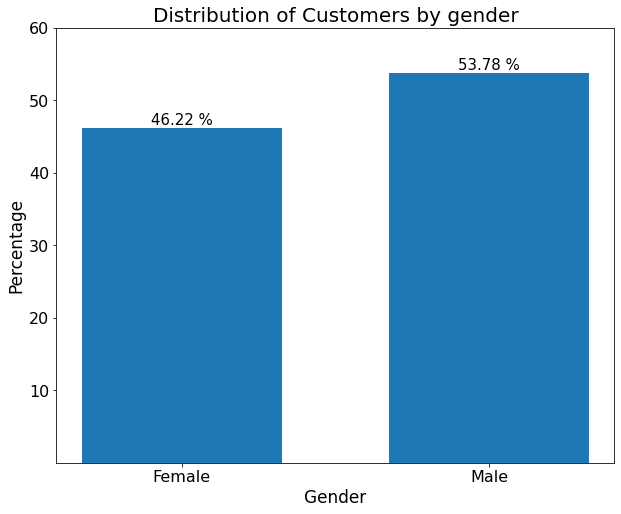

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(df_gender['gender'], height=df_gender['%'], width=0.65)
plt.title("Distribution of Customers by gender", fontsize=20)
plt.xticks(['Female', 'Male'], fontsize=16)
plt.yticks(np.arange(10, 70, 10), fontsize=16)
plt.xlabel('Gender', fontsize=17)
plt.ylabel('Percentage', fontsize=17)

for x, y in zip(df_gender['gender'], df_gender['%']):
    plt.annotate(xy=[x, y], s=str(y)+' %', fontsize=15, ha='center', va='bottom')

plt.show()

In [37]:
df.dropDuplicates(['userId', 'gender']).filter(df['churn'] == 0).count()

173

In [38]:
df.dropDuplicates(['userId', 'gender']).filter(df['churn'] == 1).count()

52

Now that we have that 53%+ of users are males, let us check how the churned users distrubuted between genders

In [39]:
df.dropDuplicates(['userId', 'gender']).groupBy(['churn', 'gender']).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



In [40]:
pdf_gen_chur = df.dropDuplicates(['userId', 'gender']).groupBy(['churn', 'gender']).count().toPandas()

In [41]:
pdf_gen_chur['churn'] = pdf_gen_chur['churn'].apply(lambda x: int(x))

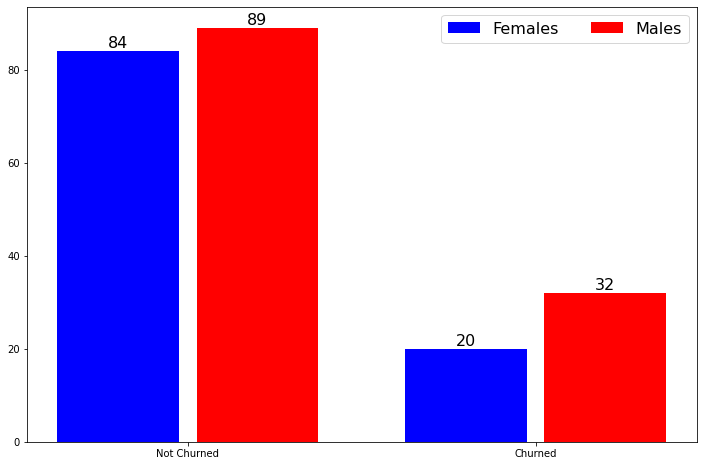

In [42]:
fig, ax = plt.subplots(figsize=[12, 8])
rect1 = ax.bar(pdf_gen_chur[pdf_gen_chur['gender'] == 'F']['churn'] - 0.2,
      pdf_gen_chur[pdf_gen_chur['gender'] == 'F']['count'],
      color='blue',
      label='Females',
      width=0.35)
rect2 = ax.bar(pdf_gen_chur[pdf_gen_chur['gender'] == 'M']['churn'] + 0.2,
      pdf_gen_chur[pdf_gen_chur['gender'] == 'M']['count'],
      color='red',
      label='Males',
      width=0.35)
for rect in rect2:
    b_height = rect.get_height()
    b_width = rect.get_width()
    b_x = rect.get_x()
    ax.text(b_x + b_width/2, 
            b_height, 
            s=b_height, 
            ha='center', 
            va='bottom',
            fontsize=16)
for rect in rect1:
    b_height = rect.get_height()
    b_width = rect.get_width()
    b_x = rect.get_x()
    ax.text(b_x + b_width/2, 
            b_height, 
            s=b_height, 
            ha='center', 
            va='bottom',
            fontsize=16)

ax.set_xticks([x for x in pdf_gen_chur[pdf_gen_chur['gender'] == 'F']['churn']])
ax.set_xticklabels(["Not Churned", "Churned"])
plt.legend(fontsize=16, ncol=2)
plt.show()

Now lets see how many paid/free users has churned

In [43]:
df.dropDuplicates(['userId', 'level']).orderBy(['level', 'churn'], ascending=False).groupby(['churn', 'level']).count().show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    1| paid|   36|
|    1| free|   46|
|    0| free|  149|
|    0| paid|  129|
+-----+-----+-----+



In [44]:
pdf_lvl_churn = df.dropDuplicates(['userId', 'level']).groupBy(['churn', 'level']).count().toPandas()

In [45]:
pdf_lvl_churn['churn'] = pdf_lvl_churn['churn'].astype(int)

<BarContainer object of 2 artists>

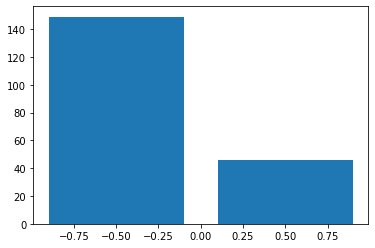

In [46]:
plt.bar(pdf_lvl_churn[pdf_lvl_churn['level'] == 'free']['churn']-0.5,
       pdf_lvl_churn[pdf_lvl_churn['level'] == 'free']['count'])

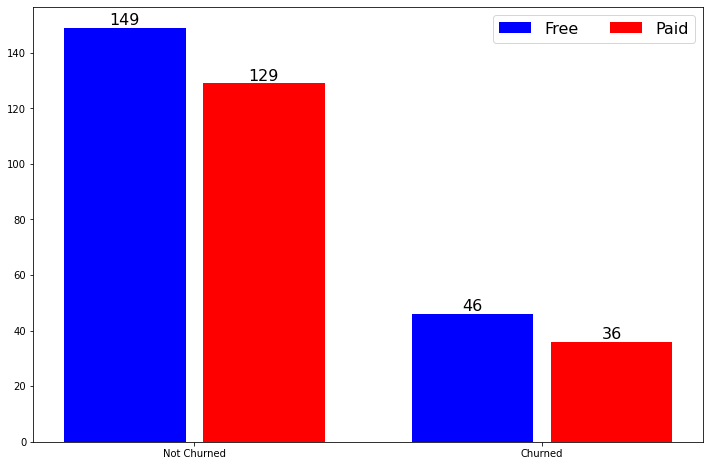

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))
rect1 = ax.bar(pdf_lvl_churn[pdf_lvl_churn['level'] == 'free']['churn'] - 0.2,
      pdf_lvl_churn[pdf_lvl_churn['level'] == 'free']['count'],
      color='blue',
      label='Free',
      width=0.35)
rect2 = ax.bar(pdf_lvl_churn[pdf_lvl_churn['level'] == 'paid']['churn'] + 0.2,
      pdf_lvl_churn[pdf_lvl_churn['level'] == 'paid']['count'],
      color='red',
      label='Paid',
      width=0.35)
for rect in rect2:
    b_height = rect.get_height()
    b_width = rect.get_width()
    b_x = rect.get_x()
    ax.text(b_x + b_width/2, 
            b_height, 
            s=b_height, 
            ha='center', 
            va='bottom',
            fontsize=16)
for rect in rect1:
    b_height = rect.get_height()
    b_width = rect.get_width()
    b_x = rect.get_x()
    ax.text(b_x + b_width/2, 
            b_height, 
            s=b_height, 
            ha='center', 
            va='bottom',
            fontsize=16)
ax.set_xticks([x for x in pdf_lvl_churn[pdf_lvl_churn['level'] == 'free']['churn']])
ax.set_xticklabels(["Churned", "Not Churned"])
plt.legend(fontsize=16, ncol=2)
plt.show()

In [48]:
df.dropDuplicates(['userId', 'churn']).groupBy(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [49]:
pdf_chrun = df.dropDuplicates(['userId', 'churn']).groupBy(['churn']).count().toPandas()

In [50]:
pdf_chrun["%"] = pdf_chrun['count'].apply(lambda x: round(x/sum(pdf_chrun['count'])*100,2))

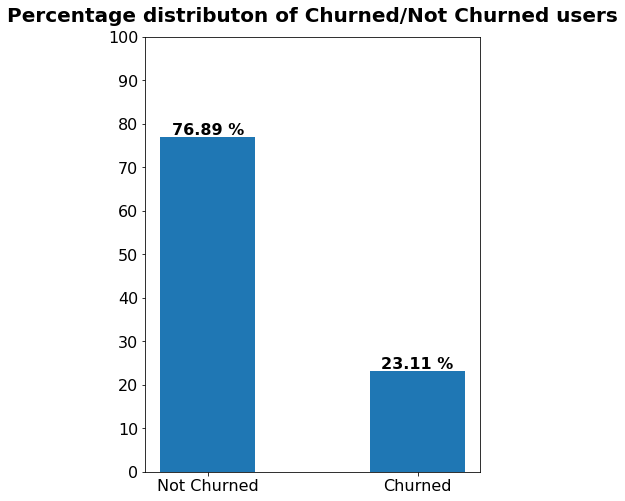

In [51]:
fig, ax = plt.subplots(figsize=(6, 8))
rects = ax.bar(pdf_chrun['churn'], height=pdf_chrun['%'], width=0.45)

ax.set_xticks([x for x in pdf_chrun['churn']])
ax.set_xticklabels(['Not Churned', 'Churned'], fontsize=16)
ax.set_title("Percentage distributon of Churned/Not Churned users", fontsize=20, fontweight='bold', pad=15)
ax.set_yticks(np.arange(0, 110, 10))
ax.set_yticklabels(np.arange(0, 110, 10), fontsize=16)
for rect in rects:
    height = rect.get_height()
    width = rect.get_width()
    b_x = rect.get_x()
    ax.text(b_x + width/2, height, s=str(height)+' %',
           ha='center', va='bottom', fontsize=16,
           fontweight='bold')

plt.show()

In [52]:
pdf_chrun

,churn,count,%
0,0,173,76.89
1,1,52,23.11


In [53]:
df_test = df.orderBy(['page', 'churn']).filter(df['page'] != 'NextSong').groupby(['churn', 'page']).count()

In [54]:
df_test.show()

+-----+----------------+-----+
|churn|            page|count|
+-----+----------------+-----+
|    0|   Save Settings|  252|
|    1|       Thumbs Up| 1859|
|    1|      Add Friend|  636|
|    1| Add to Playlist| 1038|
|    0|        Settings| 1244|
|    0|      Add Friend| 3641|
|    1|         Upgrade|  112|
|    1|          Logout|  553|
|    1|Submit Downgrade|    9|
|    1|     Thumbs Down|  496|
|    1|            Help|  239|
|    1|       Downgrade|  337|
|    1|           Error|   32|
|    0|           Error|  220|
|    0|            Help| 1215|
|    0|     Thumbs Down| 2050|
|    0|Submit Downgrade|   54|
|    1|        Settings|  270|
|    0|       Downgrade| 1718|
|    0|     Roll Advert| 2966|
+-----+----------------+-----+
only showing top 20 rows



In [55]:
pdf_page = df.filter(df['page'] != 'NextSong').groupBy(['page', 'churn']).count().orderBy(['page', 'churn']).toPandas()

For the below graph we have filtered out the 'NextSong' in order to see better the distributtion of the activity between different pages

In [56]:
pdf_page

,page,churn,count
0,About,0,439
1,About,1,56
2,Add Friend,0,3641
3,Add Friend,1,636
4,Add to Playlist,0,5488
5,Add to Playlist,1,1038
6,Cancel,1,52
7,Cancellation Confirmation,1,52
8,Downgrade,0,1718
9,Downgrade,1,337


In [57]:
df_add = pd.DataFrame({"page":['Cancel', 'Cancellation Confirmation'],
                      "churn":[0, 0],
                      "count":[0, 0]})
pdf_page = pdf_page.append(df_add)

In [58]:
pdf_page.sort_values(['page', 'churn'], inplace=True)

In [59]:
pdf_page.shape

(36, 3)

In [60]:
np.arange(0, pdf_page[pdf_page['churn'] == 0].shape[0], 1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

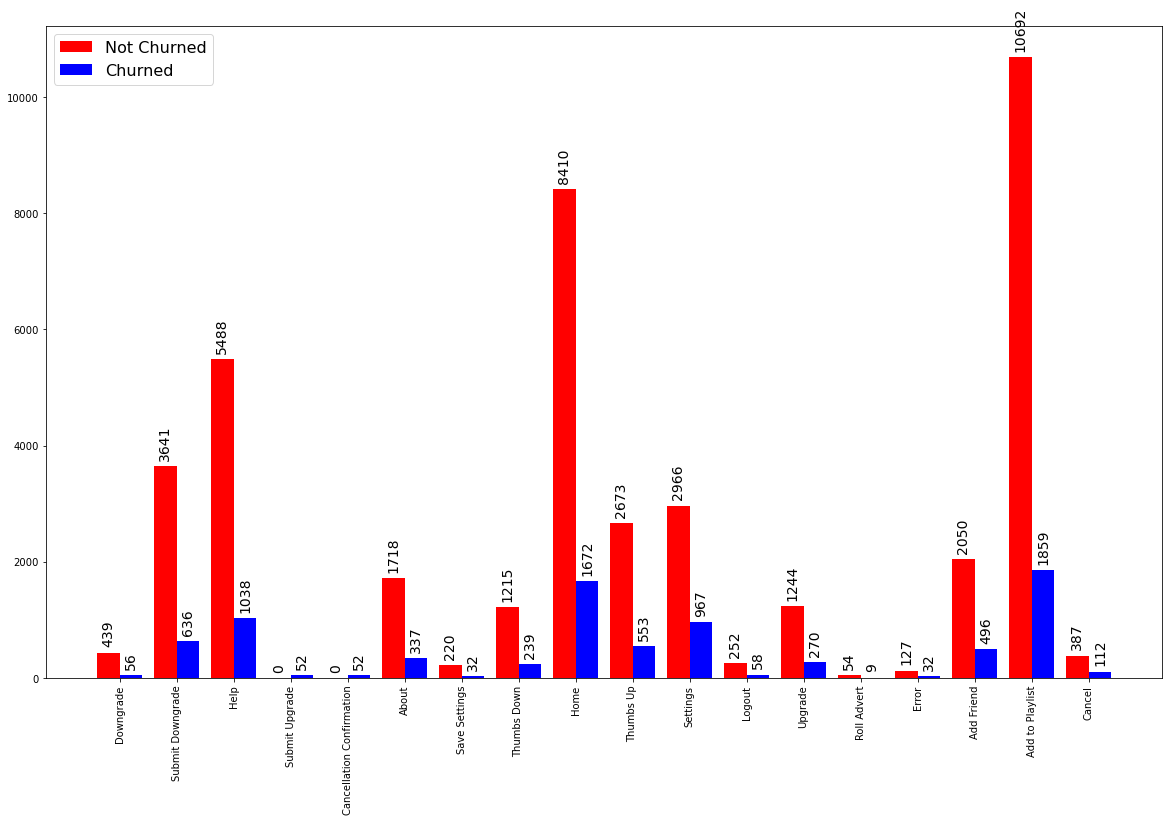

In [61]:
fig, ax = plt.subplots(figsize=(20, 12))
x_val1 = np.arange(0, pdf_page[pdf_page['churn']==0].shape[0], 1)
width = 0.4
rects1 = ax.bar(x=x_val1-width/2, 
                height=pdf_page[pdf_page['churn']==0]['count'], 
                color='red', 
                label='Not Churned', 
                width=width)
rects2 = ax.bar(x=x_val1+width/2,
                height=pdf_page[pdf_page['churn']==1]['count'], 
                color='blue', 
                label='Churned', 
                width=width)

ax.set_xticks(x_val1)

def set_datalabels(rects):
    for rect in rects:
        height = rect.get_height()
        width = rect.get_width()
        xb = rect.get_x()
        ax.text(xb + width/2, 
                height+100, 
                s=height, 
                rotation=90, 
                va='bottom', 
                ha='center', 
                fontsize=14)
        
ax.set_xticks(x_val1)
ax.set_xticklabels([x for x in set(pdf_page['page'].unique())], rotation=90)

set_datalabels(rects1)
set_datalabels(rects2)
plt.legend(fontsize=16)
plt.show()

Let us see how it looks like based on percentage.

In [62]:
df_not_c = pdf_page[pdf_page['churn'] == 0].copy()

In [63]:
df_not_c["%"] = df_not_c['count'].apply(lambda x: round(x/sum(df_not_c['count'])*100, 2))

In [64]:
df_not_c

,page,churn,count,%
0,About,0,439,1.06
2,Add Friend,0,3641,8.76
4,Add to Playlist,0,5488,13.20
0,Cancel,0,0,0.00
1,Cancellation Confirmation,0,0,0.00
8,Downgrade,0,1718,4.13
10,Error,0,220,0.53
12,Help,0,1215,2.92
14,Home,0,8410,20.23
16,Logout,0,2673,6.43


In [65]:
df_c = pdf_page[pdf_page['churn'] == 1].copy()

In [66]:
df_c["%"] = df_c['count'].apply(lambda x: round(x/sum(df_c['count'])*100, 2))

In [67]:
df_c

,page,churn,count,%
1,About,1,56,0.66
3,Add Friend,1,636,7.51
5,Add to Playlist,1,1038,12.26
6,Cancel,1,52,0.61
7,Cancellation Confirmation,1,52,0.61
9,Downgrade,1,337,3.98
11,Error,1,32,0.38
13,Help,1,239,2.82
15,Home,1,1672,19.74
17,Logout,1,553,6.53


In [68]:
df_c_full = pd.concat([df_not_c, df_c])

In [69]:
df_c_full.sort_values(by=['page', 'churn'], inplace=True)

In [70]:
df_c_full

,page,churn,count,%
0,About,0,439,1.06
1,About,1,56,0.66
2,Add Friend,0,3641,8.76
3,Add Friend,1,636,7.51
4,Add to Playlist,0,5488,13.20
5,Add to Playlist,1,1038,12.26
0,Cancel,0,0,0.00
6,Cancel,1,52,0.61
1,Cancellation Confirmation,0,0,0.00
7,Cancellation Confirmation,1,52,0.61


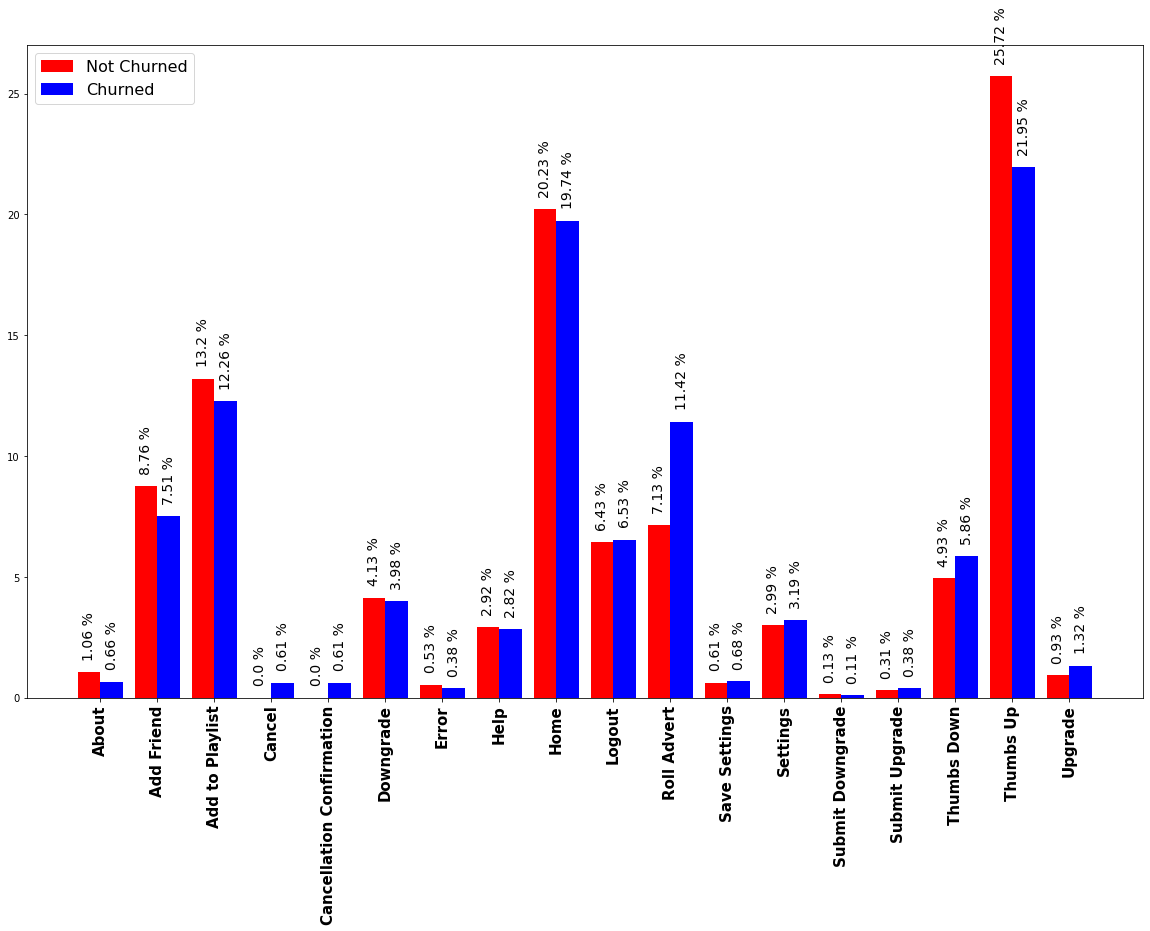

In [71]:
fig, ax = plt.subplots(figsize=(20, 12))
x_val1 = np.arange(0, df_c_full[df_c_full['churn']==0].shape[0], 1)
width = 0.4
rects1 = ax.bar(x=x_val1-width/2, 
                height=df_c_full[df_c_full['churn']==0]['%'], 
                color='red', 
                label='Not Churned', 
                width=width)
rects2 = ax.bar(x=x_val1+width/2,
                height=df_c_full[df_c_full['churn']==1]['%'], 
                color='blue', 
                label='Churned', 
                width=width)

ax.set_xticks(x_val1)

def set_datalabels(rects):
    for rect in rects:
        height = rect.get_height()
        width = rect.get_width()
        xb = rect.get_x()
        ax.text(xb + width/2, 
                height+0.5, 
                s=str(height)+" %", 
                rotation=90, 
                va='bottom', 
                ha='center', 
                fontsize=14)
        
ax.set_xticks(x_val1)
ax.set_xticklabels([x for x in df_c_full['page'].unique()], rotation=90, fontsize=15, fontweight='bold')

set_datalabels(rects1)
set_datalabels(rects2)
plt.legend(fontsize=16)
plt.show()

Based on the above data we can get some information about users that churned:
- <b>Roll Advert</b> - we can see that we have significant amount of the people is annoyed by advertisments
- <b>Thumbs Down</b> - based on this we can assume that users did not like the songs or the selection (it is possible that suggestion of the songs was not up to the taste of the User - algorithm needs some improvements?)
- <b>Settings</b> - looks like users that churned has also slightly higher percentage of visiting settings, maybe they are looking for functionality that was in other apps or/and it is a bit confusing for the to navigate

Next step lets look at the location of the users

In [72]:
df.dropDuplicates(['userId', 'location']).groupBy(['location', 'churn']).count().show()

+--------------------+-----+-----+
|            location|churn|count|
+--------------------+-----+-----+
|        Logan, UT-ID|    0|    1|
|Boston-Cambridge-...|    0|    5|
|New York-Newark-J...|    1|    5|
|        Billings, MT|    0|    1|
|Allentown-Bethleh...|    0|    1|
|Hagerstown-Martin...|    0|    1|
|San Diego-Carlsba...|    0|    2|
|Chicago-Napervill...|    1|    1|
|Orlando-Kissimmee...|    1|    1|
|       Fairbanks, AK|    0|    1|
|Tampa-St. Petersb...|    0|    2|
|Phoenix-Mesa-Scot...|    0|    5|
|Virginia Beach-No...|    0|    1|
|         Raleigh, NC|    0|    1|
|Birmingham-Hoover...|    1|    1|
|   Oklahoma City, OK|    0|    1|
|San Antonio-New B...|    0|    2|
|Baltimore-Columbi...|    0|    1|
|           Price, UT|    0|    1|
|New York-Newark-J...|    0|   10|
+--------------------+-----+-----+
only showing top 20 rows



based on the above we will need to split location into city and state

In [73]:
get_state = udf(lambda x: x.split(',')[1].strip())

In [74]:
df = df.withColumn('State', get_state(df['location']))

In [75]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- State: string (nullable = true)



In [76]:
df.groupBy(['State', 'churn']).count().orderBy(['State', 'churn'], ascending=False).show()

+-----------+-----+-----+
|      State|churn|count|
+-----------+-----+-----+
|         WV|    0| 2278|
|         WI|    0| 1342|
|         WA|    1| 3526|
|         WA|    0|  246|
|      VA-NC|    1|  149|
|      VA-NC|    0|   97|
|         VA|    0| 4651|
|      UT-ID|    0|  317|
|         UT|    0| 1102|
|         TX|    1| 1294|
|         TX|    0|22200|
|      TN-VA|    0| 1863|
|   TN-MS-AR|    1|   62|
|         TN|    0| 1672|
|      SC-NC|    0|  837|
|         SC|    1|  494|
|         SC|    0|  174|
|      RI-MA|    0|  927|
|PA-NJ-DE-MD|    1| 1580|
|PA-NJ-DE-MD|    0| 4310|
+-----------+-----+-----+
only showing top 20 rows



In [77]:
pdf_states = df.groupBy(['State', 'churn']).count().orderBy(['State', 'churn'], ascending=False).toPandas()

In [78]:
pdf_states[pdf_states['churn'] == 0]['State'].shape, pdf_states[pdf_states['churn'] == 1]['State'].shape

((54,), (29,))

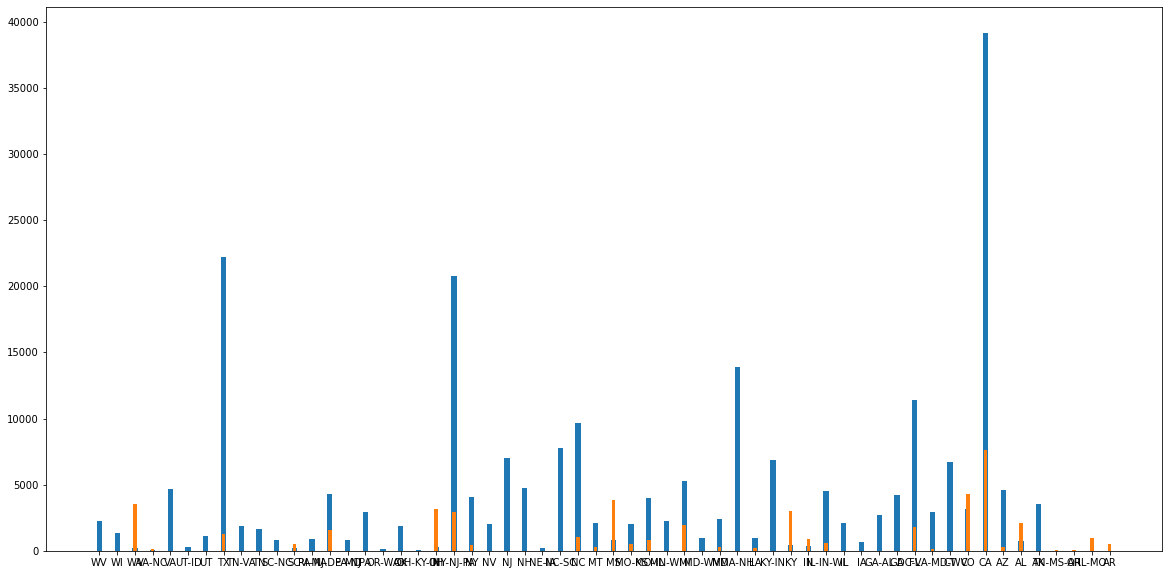

In [79]:
fig, ax = plt.subplots(figsize=[20, 10])
ax.bar(x=pdf_states[pdf_states['churn'] == 0]['State'],
      height=pdf_states[pdf_states['churn'] == 0]['count'],
      width=0.3)
ax.bar(x=pdf_states[pdf_states['churn'] == 1]['State'],
      height=pdf_states[pdf_states['churn'] == 1]['count'],
      width=0.2)

plt.show()

Let us normalize the data and display it as percentage

In [80]:
pdf_s1 = pdf_states[pdf_states['churn'] == 0].copy()
pdf_s2 = pdf_states[pdf_states['churn'] == 1].copy()

In [81]:
pdf_s2['State'].unique()

array(['WA', 'VA-NC', 'TX', 'TN-MS-AR', 'SC', 'PA-NJ-DE-MD', 'OR', 'OH',
       'NY-NJ-PA', 'NY', 'NC', 'MT', 'MS', 'MO-KS', 'MO-IL', 'MI', 'MD',
       'LA', 'KY', 'IN', 'IL-MO', 'IL-IN-WI', 'FL', 'DC-VA-MD-WV', 'CO',
       'CA', 'AZ', 'AR', 'AL'], dtype=object)

In [82]:
all_states = list(pdf_s1['State'].unique()) + list(pdf_s2['State'].unique())

In [83]:
states_f = set(all_states)

In [84]:
len(states_f)

58

In [85]:
pdf_s1.head()

,State,churn,count
0,WV,0,2278
1,WI,0,1342
3,WA,0,246
5,VA-NC,0,97
6,VA,0,4651


In [86]:
diff_s1 = states_f - set(pdf_s1["State"].unique())
pdf_s1 = pdf_s1.append(pd.DataFrame({"State":list(diff_s1),
                           "churn":len(diff_s1)*[0],
                           'count':len(diff_s1)*[0],
                           '%':len(diff_s1)*[0]}))

In [87]:
len(diff_s1)

4

In [88]:
pdf_s1.sort_values('State')

,State,churn,count,%
82,AK,0,3563,NaN
81,AL,0,755,NaN
3,AR,0,0,0.0
78,AZ,0,4595,NaN
76,CA,0,39158,NaN
74,CO,0,3176,NaN
72,CT,0,6720,NaN
71,DC-VA-MD-WV,0,2932,NaN
69,FL,0,11427,NaN
67,GA,0,4236,NaN


In [89]:
diff_s2 = states_f - set(pdf_s2["State"].unique())
pdf_s2 = pdf_s2.append(pd.DataFrame({"State":list(diff_s2),
                                    "churn":len(diff_s2)*[1],
                                    'count':len(diff_s2)*[0],
                                    '%':len(diff_s2)*[0]}))
pdf_s2.reset_index(inplace=True)
pdf_s2.drop('index', axis=1, inplace=True)

In [90]:
pdf_s1.shape, pdf_s2.shape

((58, 4), (58, 4))

In [91]:
pdf_s2.sort_values('State')

,State,churn,count,%
39,AK,1,0,0.0
28,AL,1,2102,NaN
27,AR,1,520,NaN
26,AZ,1,251,NaN
25,CA,1,7613,NaN
24,CO,1,4317,NaN
42,CT,1,0,0.0
23,DC-VA-MD-WV,1,158,NaN
22,FL,1,1763,NaN
44,GA,1,0,0.0


In [92]:
pdf_s1['%'] = round(pdf_s1['count']/pdf_s1['count'].sum()*100, 2)
pdf_s2['%'] = round(pdf_s2['count']/pdf_s2['count'].sum()*100, 2)

In [93]:
pdf_states = pd.concat([pdf_s1, pdf_s2])
pdf_states.sort_values("State", inplace=True)
pdf_states = pdf_states.groupby(['State', 'churn']).sum()
pdf_states.reset_index(inplace=True)
pdf_states

,State,churn,count,%
0,AK,0,3563,1.53
1,AK,1,0,0.00
2,AL,0,755,0.32
3,AL,1,2102,4.69
4,AR,0,0,0.00
...,...,...,...,...
111,WA,1,3526,7.86
112,WI,0,1342,0.58
113,WI,1,0,0.00
114,WV,0,2278,0.98


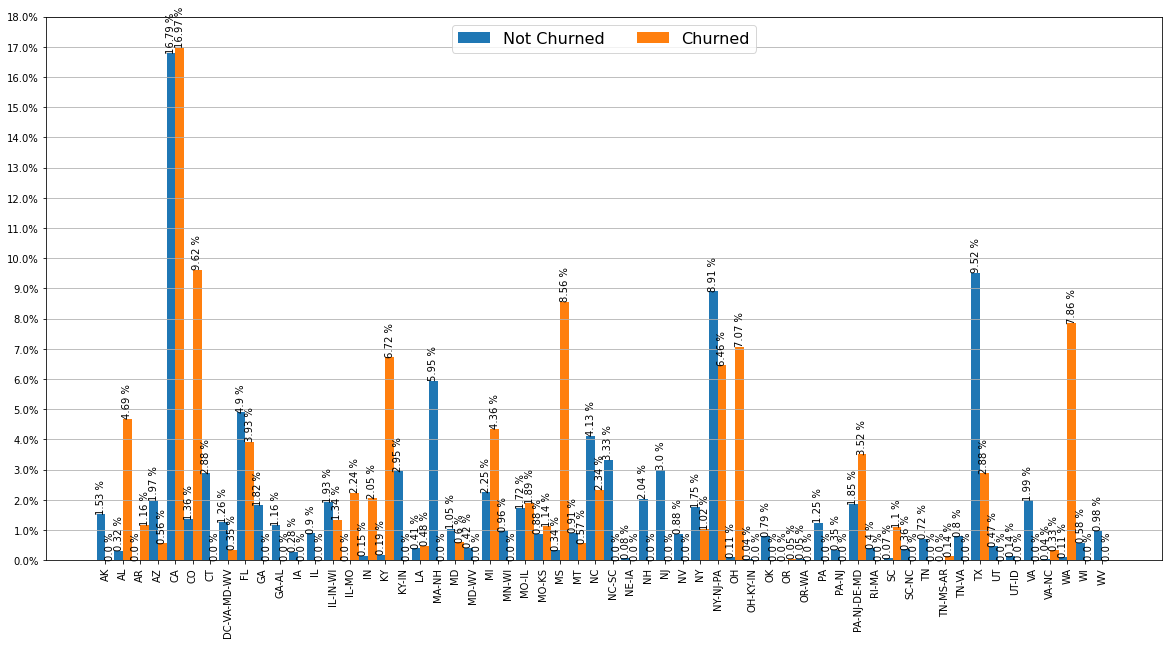

In [94]:
fig, ax = plt.subplots(figsize=[20, 10])

x_range = np.arange(len(pdf_states[pdf_states['churn']==0]))

rects1 = ax.bar(x=x_range-0.25,
      height=pdf_states[pdf_states['churn'] == 0]['%'],
      width=0.5,
      label='Not Churned')
rects2 = ax.bar(x=x_range+0.25,
      height=pdf_states[pdf_states['churn'] == 1]['%'],
      width=0.5,
      label='Churned')
ax.set_xticks(x_range)
ax.set_xticklabels(np.array(pdf_states[pdf_states['churn']==0]['State']), rotation=90)
ax.set_yticks(np.arange(0, max(pdf_states[pdf_states['churn']==0]['%'])+2, 1))
ax.set_yticklabels([str(x)+'%' for x in np.arange(max(pdf_states[pdf_states['churn']==0]['%'])+2)])
ax.yaxis.grid()
plt.legend(loc='upper center', 
           ncol=2, 
           fontsize=16)

def set_datalabels(rects):
    for rect in rects:
        bheight = rect.get_height()
        bwidth = rect.get_width()
        b_x = rect.get_x()
        
        ax.text(b_x + bwidth/2, 
                bheight, 
                s=str(bheight)+" %", 
                rotation = 90, 
                fontsize=10,
                va='bottom',
                ha='center',
                color='black')
set_datalabels(rects1)
set_datalabels(rects2)

plt.show()

Well it looks like we can see that depending on the state we have some people that acutally churned more than the other states

Let's move on, maybe HTTP status will yield some better results.

In [95]:
df.dropDuplicates(['userId', 'status']).groupBy(['status', 'churn']).count().orderBy(['status', 'churn']).show()

+------+-----+-----+
|status|churn|count|
+------+-----+-----+
|   200|    0|  173|
|   200|    1|   52|
|   307|    0|  171|
|   307|    1|   52|
|   404|    0|   95|
|   404|    1|   22|
+------+-----+-----+



Again nothing significant over here

Now let us move to time exploration

In [96]:
df.show(5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|State|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|    0|   CT|
|Francesca Battist...|Logged In| Darianna|     F|            1|C

ok looks like ts (timestamp) is in miliseconds

In [97]:
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import date_format
from pyspark.sql.functions import weekofyear
from pyspark.sql.functions import hour

In [98]:
df = df.withColumn('ts2', to_timestamp(df['ts']))

In [99]:
df.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+--------------------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|State|                 ts2|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+--------------------+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|   NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|    0|

In [100]:
# lets start by getting week of year
df.withColumn('year', date_format(df['ts2'], "yyyy")) \
.withColumn('month', date_format(df['ts2'], "MM")) \
.withColumn('day', date_format(df['ts2'], 'dd')) \
.withColumn('weekofyear', weekofyear('ts2')) \
.withColumn('dayofweek', date_format(df['ts2'], 'E')) \
.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+--------------------+------+-----+---+----------+---------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|State|                 ts2|  year|month|day|weekofyear|dayofweek|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+--------------------+------+-----+---+----------+---------+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PU

In [101]:
df_time = df.withColumn('year', date_format(df['ts2'], "yyyy")) \
.withColumn('month', date_format(df['ts2'], "MM")) \
.withColumn('day', date_format(df['ts2'], 'dd')) \
.withColumn('weekofyear', weekofyear('ts2')) \
.withColumn('dayofweek', date_format(df['ts2'], 'E'))

In [102]:
df_time.groupby(['dayofweek', 'churn']).count().orderBy(['dayofweek', 'churn']).show()

+---------+-----+-----+
|dayofweek|churn|count|
+---------+-----+-----+
|      Fri|    0|33328|
|      Fri|    1| 6405|
|      Mon|    0|33202|
|      Mon|    1| 6346|
|      Sat|    0|33452|
|      Sat|    1| 6397|
|      Sun|    0|33558|
|      Sun|    1| 6389|
|      Thu|    0|33180|
|      Thu|    1| 6542|
|      Tue|    0|33100|
|      Tue|    1| 6398|
|      Wed|    0|33470|
|      Wed|    1| 6387|
+---------+-----+-----+



In [103]:
df_time.groupby(['month', 'churn']).count().orderBy(['month', 'churn']).show()

+-----+-----+-----+
|month|churn|count|
+-----+-----+-----+
|   01|    0|19933|
|   01|    1| 3655|
|   02|    0|18404|
|   02|    1| 3461|
|   03|    0|20167|
|   03|    1| 3982|
|   04|    0|19501|
|   04|    1| 3984|
|   05|    0|19890|
|   05|    1| 4004|
|   06|    0|18961|
|   06|    1| 3677|
|   07|    0|19771|
|   07|    1| 3786|
|   08|    0|19673|
|   08|    1| 3754|
|   09|    0|19275|
|   09|    1| 3557|
|   10|    0|19662|
|   10|    1| 3586|
+-----+-----+-----+
only showing top 20 rows



In [104]:
df_time.groupby(['weekofyear', 'churn']).count().orderBy(['weekofyear', 'churn']).show()

+----------+-----+-----+
|weekofyear|churn|count|
+----------+-----+-----+
|         1|    0| 4453|
|         1|    1|  849|
|         2|    0| 4479|
|         2|    1|  817|
|         3|    0| 4543|
|         3|    1|  814|
|         4|    0| 4496|
|         4|    1|  809|
|         5|    0| 4478|
|         5|    1|  863|
|         6|    0| 4543|
|         6|    1|  839|
|         7|    0| 4599|
|         7|    1|  817|
|         8|    0| 4570|
|         8|    1|  875|
|         9|    0| 4566|
|         9|    1|  897|
|        10|    0| 4452|
|        10|    1|  873|
+----------+-----+-----+
only showing top 20 rows



In [105]:
df_time = df_time.withColumn('hour', hour(df_time['ts2']))

In [106]:
df_time.groupby(['hour', 'churn']).count().orderBy(['hour', 'churn']).show()

+----+-----+-----+
|hour|churn|count|
+----+-----+-----+
|   0|    0| 9680|
|   0|    1| 1899|
|   1|    0| 9737|
|   1|    1| 1922|
|   2|    0| 9795|
|   2|    1| 1819|
|   3|    0| 9661|
|   3|    1| 1962|
|   4|    0| 9844|
|   4|    1| 1844|
|   5|    0| 9819|
|   5|    1| 1834|
|   6|    0| 9602|
|   6|    1| 1900|
|   7|    0| 9798|
|   7|    1| 1951|
|   8|    0| 9569|
|   8|    1| 1774|
|   9|    0| 9641|
|   9|    1| 1823|
+----+-----+-----+
only showing top 20 rows



In [107]:
pdf_hours = df_time.groupby(['hour', 'churn']).count().orderBy(['hour', 'churn']).toPandas()

In [108]:
pdf_h1 = pdf_hours[pdf_hours['churn'] == 0]
pdf_h2 = pdf_hours[pdf_hours['churn'] == 1]

In [109]:
pdf_h1['%'] = round(pdf_h1['count']/pdf_h1['count'].sum()*100, 2)
pdf_h2['%'] = round(pdf_h2['count']/pdf_h2['count'].sum()*100, 2)

/Users/soundoffear/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/soundoffear/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [110]:
pdf_h1['count'].sum()

233290

In [111]:
pdf_hours = pd.concat([pdf_h1, pdf_h2])

In [112]:
pdf_hours.sort_index(inplace=True)
pdf_hours

,hour,churn,count,%
0,0,0,9680,4.15
1,0,1,1899,4.23
2,1,0,9737,4.17
3,1,1,1922,4.28
4,2,0,9795,4.20
5,2,1,1819,4.05
6,3,0,9661,4.14
7,3,1,1962,4.37
8,4,0,9844,4.22
9,4,1,1844,4.11


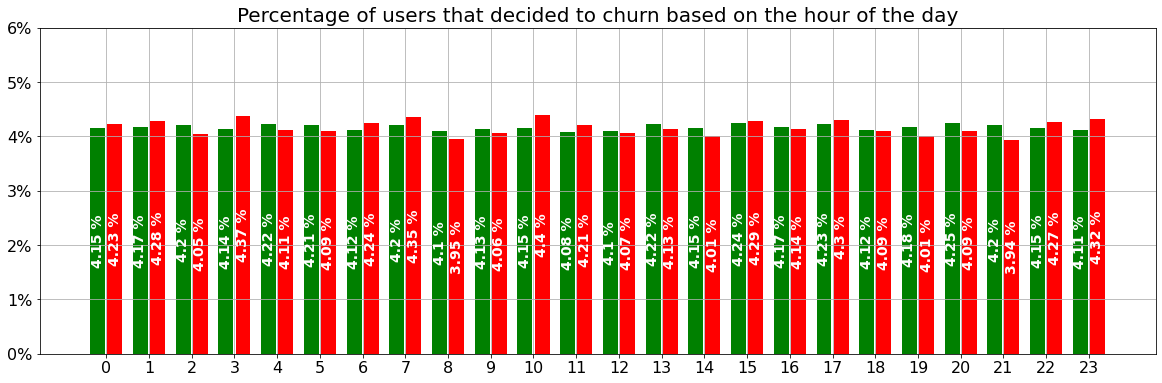

In [113]:
fig, ax = plt.subplots(figsize=(20, 6))
rects1 = ax.bar(pdf_hours[pdf_hours['churn'] == 0]['hour']-0.2, 
       pdf_hours[pdf_hours['churn'] == 0]['%'], 
       width=0.35, 
       color='green', label='Not Churned')
rects2 = ax.bar(pdf_hours[pdf_hours['churn'] == 1]['hour']+0.2, 
       pdf_hours[pdf_hours['churn'] == 1]['%'], 
       width=0.35, 
       color='red', label='Churned')
ax.set_xticks(np.arange(0, 24, 1))
ax.set_xticklabels(np.arange(0, 24, 1), fontsize=16)
ax.set_yticks(np.arange(0, 7, 1))
ax.set_yticklabels([str(x)+"%" for x in range(7)], fontsize=16)
ax.grid(True)

def set_datalabels(rects):
    for rect in rects:
        bheight = rect.get_height()
        bwidth = rect.get_width()
        bx = rect.get_x()
        
        ax.text(x=bx+bwidth/2, 
                y=bheight/2, 
                s=str(bheight)+' %', 
                fontsize=14, 
                color='white', 
                rotation=90, 
                fontweight='bold', 
                va='center', 
                ha='center')
        
set_datalabels(rects1)
set_datalabels(rects2)
plt.title("Percentage of users that decided to churn based on the hour of the day", fontsize=20)
plt.show()

In [114]:
df = df.withColumn('year', date_format(df['ts2'], "yyyy")) \
.withColumn('month', date_format(df['ts2'], "MM")) \
.withColumn('day', date_format(df['ts2'], 'dd')) \
.withColumn('weekofyear', weekofyear('ts2')) \
.withColumn('dayofweek', date_format(df['ts2'], 'E')) \
.withColumn('hour', hour(df_time['ts2']))

We can see easily that more people churned between 9 and 15, I guess not enough sleep? :P

Let us see how many songs have each user played

In [115]:
df.filter(df['song'] != 'null').groupby(['userId']).count().orderBy('userId', ascending=True).show()

+------+-----+
|userId|count|
+------+-----+
|    10|  673|
|   100| 2682|
|100001|  133|
|100002|  195|
|100003|   51|
|100004|  942|
|100005|  154|
|100006|   26|
|100007|  423|
|100008|  772|
|100009|  518|
|100010|  275|
|100011|   11|
|100012|  476|
|100013| 1131|
|100014|  257|
|100015|  800|
|100016|  530|
|100017|   52|
|100018| 1002|
+------+-----+
only showing top 20 rows



Last (but not least) we will look at userAgent, which basically is what system the user is using

Lets first check how the distinct values look like in the dataset, then we can possibly try to categorize them based on the values and asing to operating system etc.

In [116]:
df.select(['userAgent']).distinct().collect()

[Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW6

In [117]:
def user_agent_def(x):
    if 'Mac' in x:
        return 'Mac'
    elif 'Windows' in x:
        return 'Win'
    elif 'Linux' in x:
        return 'Lin'
    elif 'iPhone' in x:
        return 'Mac'
    else:
        return x

In [118]:
agent_cat = udf(user_agent_def)

In [119]:
df.withColumn('System', agent_cat('userAgent')).dropDuplicates(['userId', 'System']).groupby(['System', 'churn']).count().show()

+------+-----+-----+
|System|churn|count|
+------+-----+-----+
|   Win|    1|   24|
|   Win|    0|   87|
|   Mac|    1|   23|
|   Mac|    0|   79|
|   Lin|    1|    5|
|   Lin|    0|    7|
+------+-----+-----+



This looks promissing, especially that we have 40%+ on the Linux side, Windows and MacOS looks quite similar.

Another value that we could check is how long the user was with us, meaning how many days/hour/weeks user was active.

In [124]:
from pyspark.sql.functions import col
from pyspark.sql.functions import max as smax
from pyspark.sql.functions import min as smin

In [127]:
df.select(['userId', 'ts']).groupby(['userId']).agg(((smax(col('ts')) - smin(col('ts')))/86400000).alias('DaysIn')).show()

+------+-------------------+
|userId|             DaysIn|
+------+-------------------+
|100010|  44.21780092592593|
|200002| 45.496805555555554|
|   125|0.02053240740740741|
|    51| 15.779398148148148|
|   124| 59.996944444444445|
|     7| 50.784050925925925|
|    54|  42.79719907407407|
|    15|  54.77318287037037|
|   155|  25.82783564814815|
|   132|  50.49740740740741|
|   154| 24.986458333333335|
|100014| 41.244363425925926|
|   101| 15.861481481481482|
|    11| 53.241585648148146|
|   138|  56.07674768518518|
|300017|  59.11390046296296|
|    29|  43.32092592592593|
|    69|  50.98648148148148|
|100021| 45.457256944444445|
|    42|  60.08825231481482|
+------+-------------------+
only showing top 20 rows



There is probably much more to explore but we will now move to feature engineering, and see how base on information that we have gained so far we could fit some of our models.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Let's start with selecting features that we would like to have in our dataset for training models

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.